# HCI 2017 Week 9 - Principal Component Analysis
*Matthew Kenworthy // Leiden Observatory*

Today we cover the implementation of Principal Component Analysis as described in [Amara and Quanz (2012)](http://adsabs.harvard.edu/abs/2012MNRAS.427..948A). Go and read Section 3.1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, clobber=True)

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def cen_rot2 (im, rot, dim_out, offset1=(0,0), offset2=(0,0), order=2):
    """cen_rot2 - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot.
                """
    from scipy.ndimage import affine_transform
    a = rot * np.pi / 180.
    
    # make a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    
    # calculate total offset for image output

    # determine centre of input image

    # -0.5 is there for fencepost counting error
    c_in = np.array(offset1) - 0.5
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-rotated to make offset correct
    offset = c_in - c_out.dot(transform) - np.array(offset2).dot(transform)
    
    # perform the transformation
    dst=affine_transform( \
        im,transform.T, order=order,offset=offset, \
        output_shape=dim_out, cval=0.0)
    return(dst)

def derot(imin, rotangle, out_dims, star_cen):
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_rot2(frame_sq, rotangle[j], out_dims, offset1=star_cen)
        im_out[j,:,:] = frame_rot
        
    return(im_out)    

## Data of the planetary system HR 8799

The data is from the [NIRC2](https://www2.keck.hawaii.edu/inst/nirc2/) camera on the Keck II 10m telescope, from observing program U159N2 by Bruce Macintosh. This data is courtesy of Travis Barman. Image registration by Raphael Galicher. 

The data is taken in the L prime (Lp) filter (covers 3.42 to 4.12 microns in wavelength), in the narrow camera pixel scale (10mas/pixel)

https://www2.keck.hawaii.edu/inst/nirc2/genspecs.html

## Image data and position angle data
The data is approximately 100 images taken over the course of one night on Keck in 2009. Keck is an Alt-az telescope, so the sky rotates in the camera field of view. To derotate the images so that they are all aligned on the sky, you need a list of derotation angles, provided in `rotnth.fits`. You can read it in the same way as the data cube file.

To save storage sapce, this cube is a cropped version of the data from the earlier Practicum. The sky background is **already subtracted** from this data set, so you do not need to do it again.


In [2]:
# read in the data cube
Im, He = fits.getdata('im_week10.fits.gz', header = True)

# read in the rotation angles
Rot = fits.getdata('rotnth.fits')


## Performing regular ADI

First, we will perform a regular ADI reduction, but this time using an annular mask and numpy Broadcasting to pull out the required pixels from the data cube.

### Defining an annulus

Assume that the star is in the centre of each image slice.

Make a mask `m` that has the same dimensions as a single image slice, with inner radius of 10 pixels and outer radius of 120 pixels. Display this image with `imshow()`.

**Q1 (2 points):** Print out the numer of pixels in the annular region and print out the shape of mask `m`.

Number of pixels in the annular region: 44928
Shape of mask 'm': (300, 300)


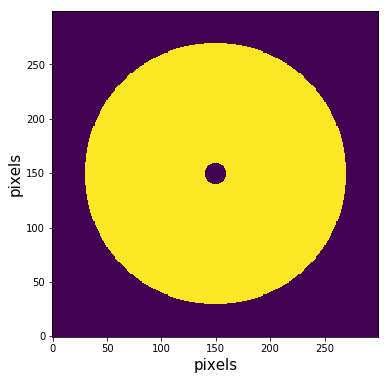

In [3]:
# Q1 answer here
pix_X, pix_Y = Im[0].shape

xc    = (pix_X - 1.0) / 2.0
yc    = (pix_Y - 1.0) / 2.0

r, angle = r_theta(Im[0], xc, yc)
m        = ( (r > 10) * (r < 120) )

plt.figure(figsize = (8,6))
plt.imshow(m)
plt.xlabel('pixels', size = 15)
plt.ylabel('pixels', size = 15)

Pixels_m = np.sum(m)
print("Number of pixels in the annular region:", Pixels_m)
print("Shape of mask 'm':", m.shape)

## Using broadcasting to select annular regions through the whole data cube

You've used broadcasting during this course to select columns and lines through data cubes and to generate functions. You can also use 2D masks to select data from a 3D data cube.

You can use a mask to select pixels from a 2D image like so:
    
    ann_pix = im[5,:][m]
    print ann_pix
    (44928,)
   
Notice that the mask selection has flattened the output array into a 1D numpy vector.

If your data cube has a shape of `[X,Y,N]` and your mask has a shape of `[X,Y]`, then `image[mask]` will broadcast across `N` to output a 2D array containing `N` columns with `1D` vectors.

The dimensions of `im` are in the wrong order, though. To reorder them, use `np.swapaxes()` to rearrange the order of dimensions in `im` and then use the annulus mask to pull out all annulus pixels in the data cube into an array called `A`.

**Q2 (2 points):** Print the shape of `A`.

**HINT** using `print x.shape` a lot will help you understand what's going on.


In [4]:
# Q2 answer here

Im_swap = np.swapaxes(Im, 0, 2)
print(Im_swap.shape)

A = Im_swap[m]
print(A.shape)

(300, 300, 94)
(44928, 94)


Calculate the median of all the annuli and subtract it off all individual annuli. Call it `Amedsub`.

** Q3 (2 points):** Put `Amedsub` back into an empty data cube, derotate the image frames to align with the sky, and take the median of this image stack. Call this `ADImed` and `imshow()` it from a range of -500 to +500 counts. You should see three planets, with the innermost one showing lots of speckle noise next to it.

**NOTE** after you've put `Amedsub` into the data cube, you will need to rearrange the axes back when you do the derotation of the image frames!

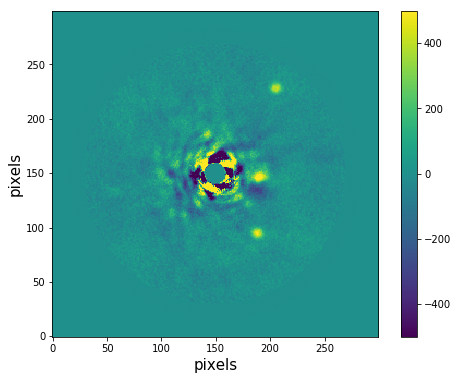

In [5]:
# Q3 answer here
Median = np.median(A, axis = 1)
Median = np.resize(Median, (44928, 1))
Amedsub        = A  - np.repeat(Median, 94, axis = 1)

AmedsubCube    = np.zeros(Im_swap.shape)
AmedsubCube[m] = Amedsub
AmedsubCube    = np.swapaxes(AmedsubCube, 0, 2)
ADImed = np.median(derot(AmedsubCube, Rot, (pix_Y, pix_X), (yc, xc)) , axis = 0)

plt.figure(figsize = (8,6))
plt.imshow(ADImed, vmin = -500, vmax = 500)
plt.xlabel('pixels', size = 15)
plt.ylabel('pixels', size = 15)
plt.colorbar()

## Computing the SVD

The next step is to now calculate the Singular Value Decomposition of `A`.

To do this, we also need to make sure that the data in each annulus has a mean of zero - check how to take the mean of one specific axis by reading the documentation on `mean(axis= ... `

**Q4 (1 point):** For `Amedsub`, calculate the mean flux in each individual annulus and subtract it off. Call this array `Ain`.

In [6]:
# Q4 answer here
Mean_Flux     = np.mean(Amedsub, axis = 0)
#Mean_Flux     = np.resize(Flux, (1, 94))
#Mean_Flux     = np.repeat(Flux, 44928, axis = 0)

Ain = Amedsub - Mean_Flux

## Performing the SVD

We now decompose `Ain` into three separate matrices using `svd`, so that:

$ Ain = U.S.V $

Where `S` is a diagonal matrix where the diagonal elements are the eigenvalues, `U` contains columns of eigenvectors, and `V` contains rows of eigenvectors.


In [7]:
U, s, V = np.linalg.svd(Ain, full_matrices = False)

print(U.shape)
print(s.shape)
print(V.shape)

(44928, 94)
(94,)
(94, 94)


## The size of the eigenvalues

** Q5 (2 points):** Make a `log10` plot of the eigenvalues `s`. Label the x axis 'Order number' and the y-axis 'log10 variance'.

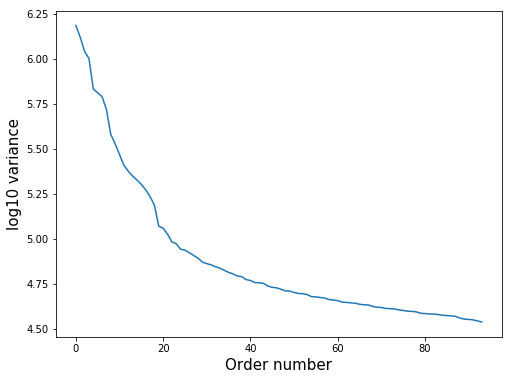

In [8]:
# Q5 answer here
plt.figure(figsize = (8,6))
plt.plot(np.log10(s))
plt.xlabel('Order number', size = 15)
plt.ylabel('log10 variance', size = 15);

The matrix multiplication:

   $C = AB$
   
in Numpy can be done with:

    C = np.dot(A,B)
    
** Q6 (2 points):** Check that $U.S.V$ is close to `Ain` by using the `np.isclose()` function and printing the fraction of elements that return `True`.

In [9]:
# Q6 answer here

S = np.diag(s)
C = np.dot(np.dot(U,S),V)

#print(np.isclose(C, Ain))

IsClose = np.isclose(C, Ain)
#print (IsClose.shape)
#print(np.sum(IsClose))
#print(IsClose.shape[0])

Pixels_total = (IsClose.shape[0] * IsClose.shape[1])
print ("\n Fraction of elements that return True", np.sum(IsClose) / Pixels_total)


 Fraction of elements that return True 0.99305792341


## Approximate the PSF with $k$ number of eigenmodes

Starting with `k=10`, make `Uk` , `Sk` and `Vk` such that you clip out the first `k` columns of `U`, the first `k` values of `s` and the first `k` rows of `V`. Sanity check my printing out the shapes of these variables.


In [10]:
k = 10

# 

Uk = U[ : , : k]
Sk = S[ : k, : k]
Vk = V[ : k, : ]

print (Uk.shape)
print (Sk.shape)
print (Vk.shape)

(44928, 10)
(10, 10)
(10, 94)


## Reconstructing the PCA PSF and subtracting it

We can now use the first $k$ eigenimages and fit them to each individual image, creating a `reconstructed` image which can then be subtracted off `Ain` to produce the PCA subtracted annuli.

After calculating `residuals` below, put it into an image array called `resid` (HINT: use the `swapaxes()` function to rearrange your `numpy` dimensions).

In [11]:
transformed = np.dot(Vk, Ain.T)

reconstructed = np.dot(transformed.T, Vk)

residuals = Ain - reconstructed
#print(residuals.shape)

# HINT: make resid with zeros_like() using im
resid    = np.zeros_like(Im_swap)
resid[m] = residuals
#residuals.shape

resid = np.swapaxes(resid, 0, 2)
#resid.shape

## Derotating the residuals and stacking together

** Q7 (4 points): ** Finally, take the data cube `resid` and derotate to the sky, and then median combine in a variable called `PCAmed`. Display both `ADImed` and `PCAmed` using `imshow()` from -400 to 400.

You can use `plt.show()` after an `imshow()` to force a new plot to appear.

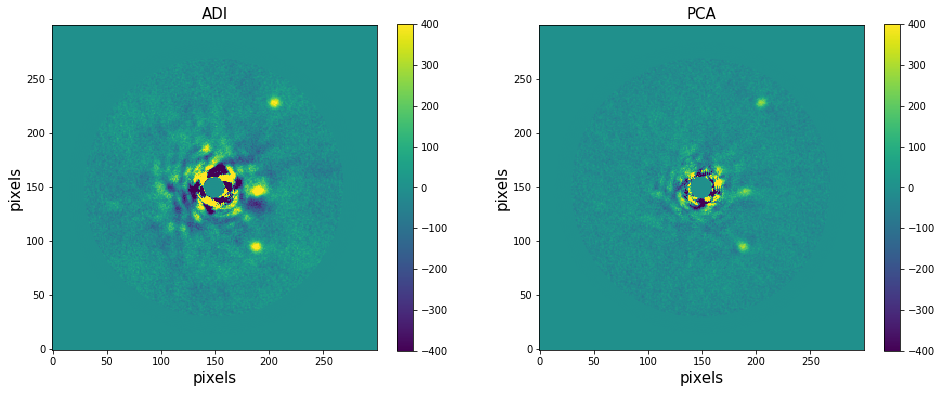

In [12]:
# Q7 answer here

resid_derot = np.median(derot(resid, Rot, (pix_Y, pix_X), (yc, xc)) , axis = 0)

fig, ((axA, axB)) = plt.subplots(figsize = (16,6), ncols = 2, nrows = 1)

A = axA.imshow(ADImed, vmin = -400, vmax = 400)
axA.set_xlabel('pixels', size = 15)
axA.set_ylabel('pixels', size = 15)
axA.set_title('ADI', size = 15)
plt.colorbar(A, ax = axA)

B = axB.imshow(resid_derot, vmin = -400, vmax = 400)
axB.set_xlabel('pixels', size = 15)
axB.set_ylabel('pixels', size = 15)
axB.set_title('PCA', size = 15)
plt.colorbar(B, ax = axB)

## Comparing median ADI and PCA

** Q8 (4 points) ** define annuli from 0.2 arcsec through to 4 arcsec in 0.1 arcsec steps. Plot the radius of the middle of width of the ring versus the r.m.s. in each the ring, ADI and for PCA for k = 5, 10, and 20. Plot them all on the same graph.

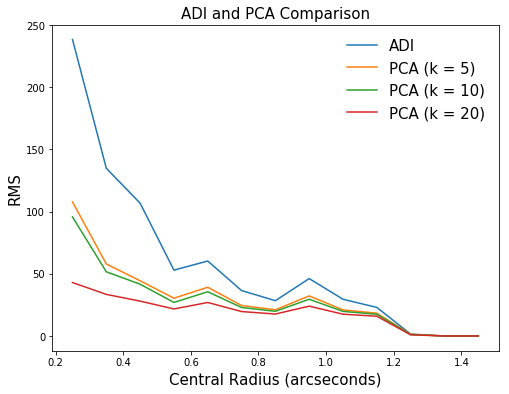

In [13]:
# Q8 answer here

Max_angle  = 1.4
Inner      = np.linspace(0.2, Max_angle, 13) # In arcseconds.
Center     = Inner + 0.05                    # In arcseconds.
pixelScale = 0.01                            # In arcseconds per pixel.
kList      = [5, 10, 20]

plt.figure(figsize = (8,6))

RMS_ADI = []
for j in range(len(Inner)):
    
    R_Inner = Inner[j] / pixelScale
    R_Outer = R_Inner + 0.1 / pixelScale
    m       = ( (r > R_Inner) * (r < R_Outer) )
    RMS_ADI.append(np.std(ADImed[m]))
    
plt.plot(Center, RMS_ADI, label = "ADI")

PCAmedCube = np.zeros((len(kList), pix_Y, pix_X))
for i in range(len(kList)):
    
    k = kList[i]
    
    Uk = U[ : , : k]
    Sk = S[ : k, : k]
    Vk = V[ : k, : ]
    
    transformed   = np.dot(Vk, Ain.T)
    reconstructed = np.dot(transformed.T, Vk)
    residuals     = Ain - reconstructed
    
    M        = ( (r > 10) * (r < 120) )
    resid    = np.zeros(Im_swap.shape)
    resid[M] = residuals
    resid    = np.swapaxes(resid, 0, 2)
    
    PCAmed = np.median(derot(resid, Rot, (pix_Y, pix_X), (yc, xc)) , axis = 0)
    PCAmedCube[i, : , : ] = PCAmed #To be used in question 9
    
    RMS_PCA = []
    for j in range(len(Inner)):
        
        R_Inner = Inner[j] / pixelScale
        R_Outer = R_Inner + 0.1 / pixelScale
        m = ((r > R_Inner) * (r < R_Outer))
        RMS_PCA.append(np.std(PCAmed[m]))
        
    plt.plot(Center, RMS_PCA, label = "PCA (k = " + str(k) + ')')

plt.legend()
plt.xlabel("Central Radius (arcseconds)", size = 15)
plt.ylabel("RMS", size = 15)
plt.title("ADI and PCA Comparison", size = 15)
plt.legend(frameon = False, loc = 'best', prop = {'size': 15});

#PCA reduces the RMS. ADI has larger RMS at inner radius. 

** Q9 (4 points):** Measure the total flux from the planet at (170,100) using a 10 pixel diameter aperture for the four images above.

What happens to the planet flux as you go to higher values of $k$?

In [14]:
# Q9 answer here

X_planet = 188 #Planet pixel position
Y_planet = 95  #Planet pixel pixel
radius   = 5   #Aperture radius

#plt.imshow(ADImed[Y_planet - radius: Y_planet + radius, X_planet - radius: X_planet + radius]) #To check planet position

print('Flux ADI %f'%(np.sum(ADImed[Y_planet - radius: Y_planet + radius, X_planet - radius: X_planet + radius])))

for k in range(len(kList)):
    print('k = %d, Flux PCA %f'%(kList[k], np.sum(PCAmedCube[k, Y_planet - radius: Y_planet + radius, X_planet - radius: X_planet + radius])))
    
#The planet flux decreases as k increases.     

Flux ADI 28550.334990
k = 5, Flux PCA 16704.850229
k = 10, Flux PCA 14718.339756
k = 20, Flux PCA 9014.455549
